In [8]:
import numpy as np
import math, random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from geometry.model import Model, combine_observations, get_mesh
from geometry.utils.visualisation import illustrate_points, illustrate_mesh

from rl.environment import Environment, CombiningObservationsWrapper
from rl.environment import StepPenaltyRewardWrapper, DepthMapWrapper
from rl.dqn import CnnDQN


# !conda install -c conda-forge pyembree
# !conda install -c conda-forge igl
# !pip install Cython
# !pip install gym

In [241]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    if len(losses) > 20:
        plt.plot(losses[20:])
    else:
        plt.plot(losses)
    plt.show()

## DQN

In [7]:
USE_CUDA = torch.cuda.is_available()

# if USE_CUDA:
#     torch.cuda.set_device(1)
#     print(torch.cuda.current_device())

Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() \
    if USE_CUDA else autograd.Variable(*args, **kwargs)

### Replay buffer

In [8]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity, use_gpu=False):
        self.buffer = deque(maxlen=capacity)
        self.use_gpu = use_gpu
    
    def push(self, state, action, reward, next_state, done):
        
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        if self.use_gpu:
            state      = Variable(torch.FloatTensor(np.float32(state)))
            next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
            action     = Variable(torch.LongTensor([action]))
            reward     = Variable(torch.FloatTensor([reward]))
            done       = Variable(torch.FloatTensor([done]))
        
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        if self.use_gpu:
            state      = torch.cat(state)
            action     = torch.cat(action)
            reward     = torch.cat(reward)
            next_state = torch.cat(next_state)
            done       = torch.cat(done)
        else:
            state      = Variable(torch.FloatTensor(np.float32(np.concatenate(state))))
            next_state = Variable(torch.FloatTensor(np.float32(np.concatenate(next_state))),
                                  volatile=True)
            action     = Variable(torch.LongTensor(action))
            reward     = Variable(torch.FloatTensor(reward))
            done       = Variable(torch.FloatTensor(done))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)



### Epsilon-greedy

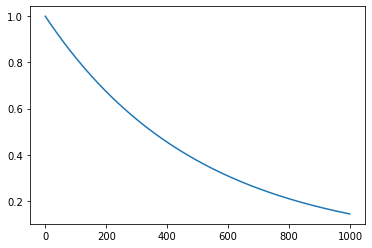

In [9]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * \
        math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(1000)])

In [7]:
def compute_td_loss_actions(batch_size, actions):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

#     state      = Variable(torch.FloatTensor(np.float32(state)))
#     next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
#     action     = Variable(torch.FloatTensor(action))
#     reward     = Variable(torch.FloatTensor(reward))
#     done       = Variable(torch.FloatTensor(done))

    q_value = model(state, action).squeeze(1)
    
    next_q_values = []
    for batch_idx in range(batch_size):
        next_q_value = -np.inf
        for next_action in actions:
            next_action = Variable(torch.FloatTensor([next_action])).unsqueeze(0)
            pred = model(next_state[batch_idx].unsqueeze(0), next_action).item()
            next_q_value = max(next_q_value, pred)
        next_q_values.append(next_q_value)

    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = torch.mean((q_value - expected_q_value) ** 2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [234]:
env = Environment(illustrate=False, model_path="./data/Dude.obj", number_of_view_points=100)
env = CombiningObservationsWrapper(env)
env = StepPenaltyRewardWrapper(env)
env = DepthMapWrapper(env)

In [10]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.001)

replay_initial = 5
replay_buffer = ReplayBuffer(20)

NameError: name 'USE_CUDA' is not defined

### Training

In [ ]:
num_frames = 15000
batch_size = 64
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state, _ = env.reset()
nof_vp = 0
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)

    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    print(len(replay_buffer))
    
    # QUESTION episode_reward += reward * self._gamma ** t

    state = next_state
    episode_reward += reward
    nof_vp += 1

    # env.render(action, state)

    if done:
#         final_reward = env.final_reward()
#         print("Number of View Points: ", nof_vp, " Hausdorff reward: ", final_reward)
        print("Frame: ", frame_idx, "Number of View Points: ", nof_vp)
        print()
        
        state, _ = env.reset()
        nof_vp = 0
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
#         print("Computing loss")
        loss = compute_td_loss(batch_size)
#         print(loss)
        losses.append(loss.item())
        
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 500 ==  0:
        torch.save(model, "./models/dude-100vp-gpu-{}.pt".format(frame_idx))

Action:  1 (random)
0.7650876054510058 0.23545316893791912 0.5296344365130867
Action:  0 (random)
0.7661691542288557 0.29574951330304994 0.47041964092580574
Action:  9 (random)
1.0 0.4704196409258058 0.5295803590741942
Frame:  3 Number of View Points:  3

Action:  8 (random)
0.6865671641791045 0.4527363184079602 0.23383084577114427
Action:  1 (random)
0.9829115293099718 0.4532770927968851 0.5296344365130867
Frame:  5 Number of View Points:  2

Action:  4 (random)
0.7608695652173914 0.46609344581440626 0.2947761194029851
